download data

In [ ]:
!rm -rf data
!wget -P data https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/VKRecsysChallenge2024/dataset/train_interactions.parquet
!wget -P data https://storage.yandexcloud.net/ds-ods/files/files/c1992ccf/users_meta.parquet
!wget -P data https://storage.yandexcloud.net/ds-ods/files/files/13b479ed/items_meta.parquet
!wget -P data https://storage.yandexcloud.net/ds-ods/files/files/0235d298/test_pairs.csv
!wget -P data https://storage.yandexcloud.net/ds-ods/files/files/55b07019/sample_submission.csv

In [ ]:
!wget https://storage.yandexcloud.net/ds-ods/files/files/82d94c5c/baseline.ipynb

install libraries

In [1]:
import numpy as np
import pandas as pd
import implicit
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split

/home/sokolov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


read data

In [2]:
data_path = Path("./data")
user_item_data_path = data_path / "train_interactions.parquet"
users_meta_data_path = data_path / "users_meta.parquet"
items_meta_data_path = data_path / "items_meta.parquet"
test_pairs_data_path = data_path / "test_pairs.csv"

In [3]:
user_item_data = pd.read_parquet(user_item_data_path)
users_meta_data = pd.read_parquet(users_meta_data_path)
items_meta_data = pd.read_parquet(items_meta_data_path)
test_pairs_data = pd.read_csv(test_pairs_data_path)

In [4]:
user_item_data.head()

,user_id,item_id,timespent,like,dislike,share,bookmarks
0,3810,138979,6,0,0,0,0
1,101874,331160,6,0,0,0,0
2,150332,73709,11,0,0,0,0
3,4982,189745,5,0,0,0,0
4,149601,289643,1,0,0,1,0


In [5]:
ui_train, ui_val = train_test_split(user_item_data,
                                    test_size=0.15,
                                    random_state=42,
                                    shuffle=False)

In [6]:
u_train = ui_train.user_id
i_train = ui_train.item_id
likes_train = ui_train.like
dislikes_train = ui_train.dislike

In [7]:
sparse_train = coo_matrix((likes_train, (u_train, i_train)))

In [8]:
model = implicit.als.AlternatingLeastSquares(factors=256)
model.fit(sparse_train)

/home/sokolov/workspace/vk_recsys/vk_env/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 4.980337381362915 seconds
  warnings.warn(
100%|██████████| 15/15 [01:37<00:00,  6.49s/it]


In [ ]:
model = model.to_cpu()

In [12]:
als_score = (model.user_factors[ui_val['user_id']] * 
             model.item_factors[ui_val['item_id']]).sum(axis=1)

In [13]:
ui_val['als_score'] = als_score

In [14]:
ui_val["target"] = ui_val["like"].astype(np.int8) - ui_val["dislike"].astype(np.int8)

In [15]:
ui_val["target"].unique()

array([ 0,  1, -1], dtype=int8)

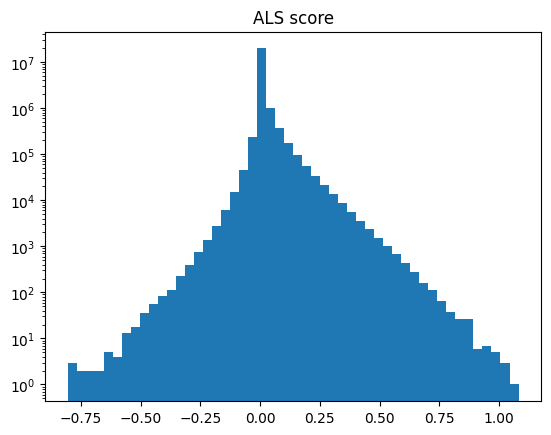

In [16]:
plt.hist(ui_val["als_score"], bins=50)
plt.title("ALS score")
plt.yscale("log")
plt.show()

In [17]:
def compare_score(score1, score2):
    if score1 > score2:
        return 0
    elif score1 == score2:
        return 0.5
    else:
        return 1
    
def compare_target(target1, target2):
    if target1 >= target2:
        return 0
    else:
        return 1

In [18]:
def roc_auc_score(y_true, y_score):
    num = 0
    denom = 0
    for i in range(len(y_true)):
        for j in range(len(y_true)):
            if i == j:
                continue
            num += compare_score(y_score[i], y_score[j])*compare_target(y_true[i], y_true[j])
            denom += compare_target(y_true[i], y_true[j])
    return num/denom if denom>0 else None

In [19]:
user_id = ui_val.user_id.values
sorting_indices = user_id.argsort()
user_id = user_id[sorting_indices]
target_and_score = ui_val[["target", "als_score"]].values
groups = np.split(target_and_score, np.unique(user_id, return_index=True)[1][1:])

In [20]:
roc_auc = []

for group in tqdm(groups):
    target = group[:,0]
    als_score = group[:,1]
    roc_auc_ = roc_auc_score(y_true=target,
                             y_score=als_score)
    if roc_auc_ is not None:
        roc_auc.append(roc_auc_)

100%|██████████| 181721/181721 [48:14<00:00, 62.78it/s] 


In [65]:
pd.set_option('display.max_rows', None)

In [93]:
from lifelines.utils import concordance_index

In [113]:
roc_auc = []

for group in tqdm(groups):
    target = group[:,0]
    als_score = group[:,1]
    if len(np.unique(target)) == 1:
        continue
    roc_auc_ = concordance_index(target, als_score)
    roc_auc.append(roc_auc_)

100%|██████████| 181721/181721 [01:28<00:00, 2049.75it/s]


In [112]:
np.mean(roc_auc)

np.float64(0.7771445286584225)

In [73]:
test_als_score = (model.user_factors[test_pairs_data['user_id']] * 
                  model.item_factors[test_pairs_data['item_id']]).sum(axis=1)

In [77]:
test_pairs_data["predict"] = test_als_score
test_pairs_data.to_csv("./submission.csv",index=False)